# Descripción del proyecto

Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.

Necesitamos predecir si un cliente dejará el banco pronto. Tú tienes los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.

Crea un modelo con el máximo valor F1 posible. Para aprobar la revisión, necesitas un valor F1 de al menos 0.59. Verifica F1 para el conjunto de prueba. 

Además, debes medir la métrica AUC-ROC y compararla con el valor F1.

## Instrucciones del proyecto


1. Descarga y prepara los datos.  Explica el procedimiento.
2. Examina el equilibrio de clases. Entrena el modelo sin tener en cuenta el desequilibrio. Describe brevemente tus hallazgos.
3. Mejora la calidad del modelo. Asegúrate de utilizar al menos dos enfoques para corregir el desequilibrio de clases. Utiliza conjuntos de entrenamiento y validación para encontrar el mejor modelo y el mejor conjunto de parámetros. Entrena diferentes modelos en los conjuntos de entrenamiento y validación. Encuentra el mejor. Describe brevemente tus hallazgos.
4. Realiza la prueba final.

## Descripción de los datos

* RowNumber: índice de cadena de datos
* CustomerId: identificador de cliente único
* Surname: apellido
* CreditScore: valor de crédito
* Geography: país de residencia
* Gender: sexo
* Age: edad
* Tenure: período durante el cual ha madurado el depósito a plazo fijo de un cliente (años)
* Balance: saldo de la cuenta
* NumOfProducts: número de productos bancarios utilizados por el cliente
* HasCrCard: el cliente tiene una tarjeta de crédito (1 - sí; 0 - no)
* IsActiveMember: actividad del cliente (1 - sí; 0 - no)
* EstimatedSalary: salario estimado

## Objetivo

* Exited: El cliente se ha ido (1 - sí; 0 - no)



## 1. Examinar los datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error


In [2]:
data = pd.read_csv('./datasets/Churn.csv')

In [3]:
# mostrar información del DataFrame
def info(df):
    display(df.head(10))
    print()
    print(df.info())
    print()
    print(df.describe())
    print()
    print('Duplicated: ',df.duplicated().sum())
    print()
    print('Null values %:')
    print(100*df.isnull().sum()/len(df))

info(data)

In [4]:
data = data.dropna()


<div class="alert alert-block alert-info">
<b>

* 100 000 clientes con 14 caracteristicas

* 9%  NaN en Tenure eliminados

* No duplicados
</b> <a class="tocSkip"></a>


In [5]:
print('Edad promedio',round(data['Age'].mean(),0))
print()
print('Salario promedio',round(data['EstimatedSalary'].mean(),0))
print()
print('Score promedio',round(data['CreditScore'].mean(),0))
print()
print('Años promedio',round(data['Tenure'].mean(),0))
print()
print('Saldo promedio',round(data['Balance'].mean(),0))
print()
print ('Nacionalidad (%)',100*(data.groupby('Geography')['Geography'].count())/len(data['Geography']))
print()
print ('Sexo (%)',100*(data.groupby('Gender')['Gender'].count())/len(data['Gender']))
print()
print('No,. de productos (%)',100*(data.groupby('NumOfProducts')['NumOfProducts'].count())/len(data['Gender']))
print()
print('Tarjeta de crédito (%)',100*(data.groupby('HasCrCard')['HasCrCard'].count())/len(data['HasCrCard']))
print()
print('Miembros activos (%)',100*(data.groupby('IsActiveMember')['IsActiveMember'].count())/len(data['IsActiveMember']))
print()
print('Se ha ido (%)',100*(data.groupby('Exited')['Exited'].count())/len(data['Exited']))



<div class="alert alert-block alert-info">
<b>

1. La edad promedio de los clientes es 39 años
2. El salario promedio de los clientes es 100 181
3. La mayoría de los clientes son de Francia (50.04%)
4. La mayoría de los clientes son hombres (54.71%)
5. La mayoría de los clientes tienen una tarjeta de crédito (70.49%)
6. La mayoría de los clientes son miembros activos (51.55%)
7. La mayoría de los clientes tienen 1 producto (50.78%)
8. La mayoría de los clientes tienen un saldo de cuenta de 76 523
9. La mayoría de los clientes tienen un puntaje de crédito de 651
10. La mayoría de los clientes han estado en el banco durante 5 años

## La mayoría de los clientes no han abandonado el banco (79.60%)

</b> <a class="tocSkip"></a>


### 1.1. Equilibrio de clases


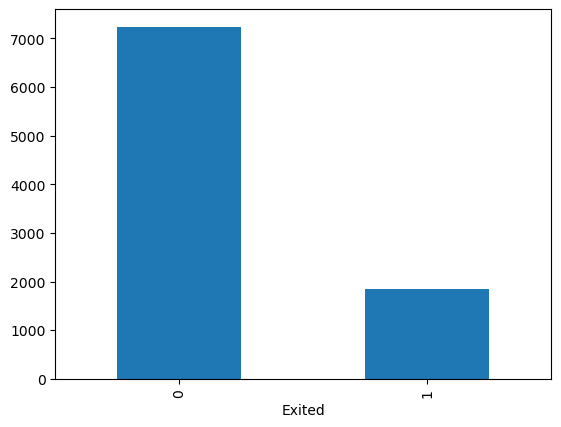

In [6]:
print('Se ha ido (%)',100*(data.groupby('Exited')['Exited'].count())/len(data['Exited']))

data.groupby('Exited')['Exited'].count().plot(kind='bar')



### 1.2 Separación de datos

In [7]:
data = data.drop(['RowNumber','CustomerId','Surname'], axis=1)
data = shuffle(data)
data = data.reset_index(drop=True)
info(data)

### 1.3 Variables ordinales

In [8]:
# 1. Crea una instancia de esta clase
encoder = OrdinalEncoder()
# 2.  Ajustarlo a tus datos para que reconozca qué variables son categóricas.
encoder.fit(data)
# 3. Transformar tus datos
data_ordinal = pd.DataFrame(encoder.fit_transform(data), columns=data.columns)
data_ordinal


### 1.4 Matriz de correlación

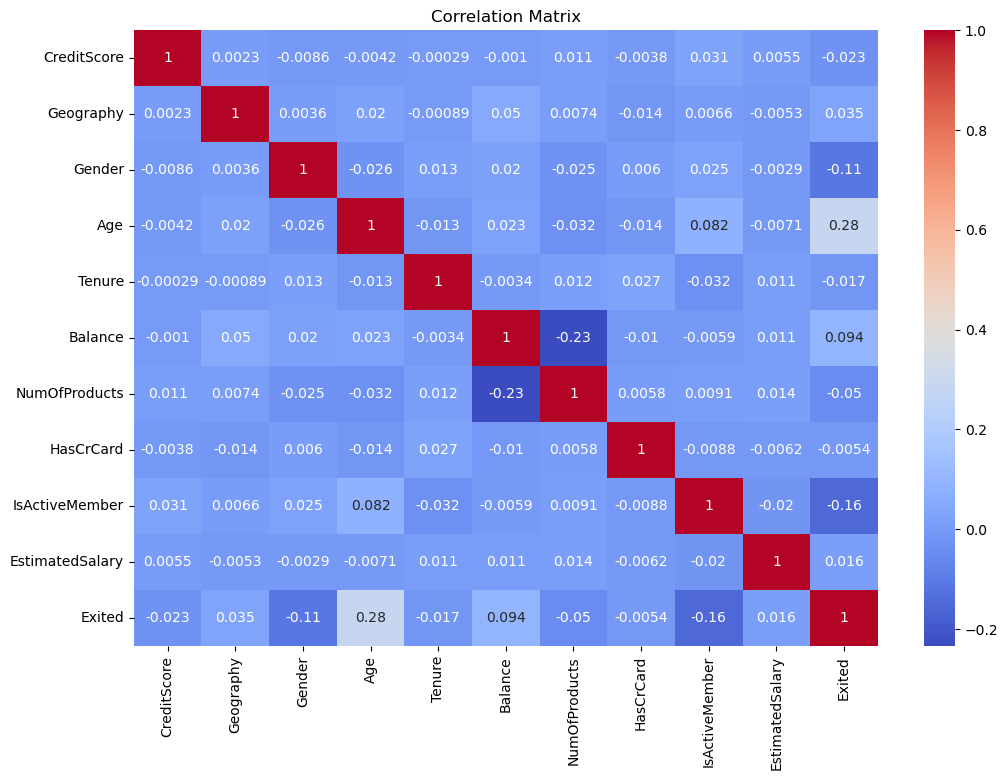

In [9]:
correlation_matrix = data_ordinal.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## 2. Segmenta los datos en un conjunto de entrenamiento, uno de validación y uno de prueba.

In [10]:
target = data_ordinal['Exited']
features = data_ordinal.drop(['Exited'], axis=1)

In [11]:
# Dividimos los datos en entrenamiento (60%) y temporal (40%) 
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.4, random_state=42)

# Dividimos el conjunto temporal en validación (20%) y prueba (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


<div class="alert alert-block alert-info">
<b>

* X: características
* Y: variable objetivo
* X_train, y_train: Conjunto de entrenamiento
* X_val, y_val: Conjunto de validación
* X_test, y_test: Conjunto de prueba

</b> <a class="tocSkip"></a>

## 3. Investigar la calidad de diferentes modelos cambiando los hiperparámetros. 

### 3.1 Regresión lineal

In [12]:
# Entrenar el modelo (train)
model = LinearRegression()
model.fit(X_train, y_train)

# Predicciones del modelo con el conjunto de validación
predictions_val = model.predict(X_val)

# Raíz cuadrática media  para validación
result_val = mean_squared_error(y_val, predictions_val)**0.5
print("RMSE del modelo de regresión lineal en el conjunto de validación:", round(result_val,4))

# Predicciones final (test)
predictions_test = model.predict(X_test)

# RSME para el conjunto de prueba
result_test = mean_squared_error(y_test, predictions_test)**0.5
print("RMSE del modelo de regresión lineal en el conjunto de prueba:", round(result_test,4))


<div class="alert alert-block alert-info">
<b>

El modelo de regresión lineal entrenado mostró un rendimiento consistente tanto en el conjunto de validación como en el conjunto de prueba:

RMSE en el Conjunto de Validación: 0.3716
RMSE en el Conjunto de Prueba: 0.3714

 Esto indica que el modelo tiene una buena capacidad de generalización y no está sobreajustado ni subajustado.

 Un RMSE de aproximadamente 0.371 en ambos conjuntos sugiere que el modelo puede predecir con precisión los valores de salida en datos nuevos, manteniendo un error bajo.

</b> <a class="tocSkip"></a>

### 3.2 Regresión logística

In [13]:
# Entrenar el modelo (train)
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
#model = LogisticRegression()
model.fit(X_train, y_train)

# Predicciones del modelo con el conjunto de validación
y_pred_val = model.predict(X_val)
# Métricas de rendimiento  para validación
accuracy_val = accuracy_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)

# Predicciones final (test)
y_pred_test = model.predict(X_test)
# Métricas de rendimiento  final
accuracy_test = accuracy_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

# Imprimir métricas
print(f"Accuracy (Validation): {accuracy_val}")
print(f"Accuracy (Test): {accuracy_test}")
print()
print(f"AUC (Validation): {auc_val}")
print(f"AUC (Test): {auc_test}")
print()
print(f"F1 (Validation): {f1_val}")
print(f"F1 (Test): {f1_test}")

<div class="alert alert-block alert-info">
<b>

- La precisión del modelo es alta en ambos conjuntos, con valores de 0.8080 en validación y 0.8131 en prueba. Esto indica que el modelo clasifica correctamente la mayoría de las instancias.

- Los valores de AUC son relativamente bajos (0.5685 en validación y 0.5627 en prueba). Esto sugiere que el modelo tiene una capacidad limitada para distinguir entre las clases positivas y negativas.

- Los valores de F1 Score son bajos (0.2559 en validación y 0.2377 en prueba), lo que indica que el modelo tiene dificultades para equilibrar la precisión y el recall, especialmente en la clase minoritaria.
 
</b> <a class="tocSkip"></a>

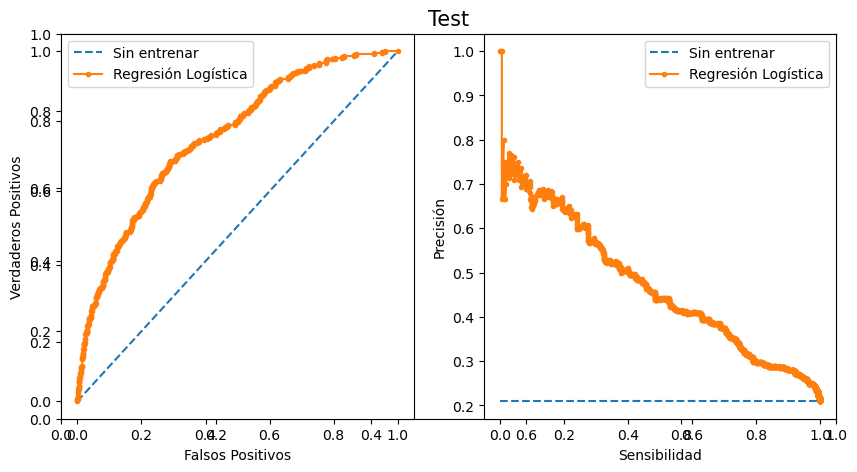

In [14]:
#Generamos un clasificador sin entrenar ,  0 a todo
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = model.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
no_train = len(y_test[y_test==1]) / len(y_test)

plt.figure(figsize=(10,5))
plt.title('Test', size = 15)
plt.subplot(1,2,1)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Regresión Logística')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.legend()
plt.subplot(1,2,2)
plt.plot([0, 1], [no_train, no_train], linestyle='--', label='Sin entrenar')
plt.plot(lr_recall, lr_precision, marker='.', label='Regresión Logística')
plt.xlabel('Sensibilidad')
plt.ylabel('Precisión')
plt.legend()
plt.show()

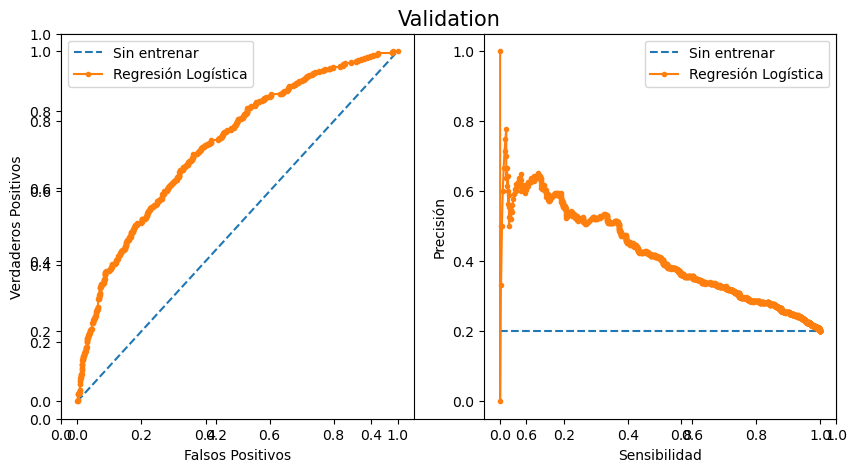

In [15]:
#Generamos un clasificador sin entrenar ,  0 a todo
ns_probs = [0 for _ in range(len(y_val))]
lr_probs = model.predict_proba(X_val)
lr_probs = lr_probs[:, 1]
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_val, lr_probs)
lr_precision, lr_recall, _ = precision_recall_curve(y_val, lr_probs)
no_train = len(y_val[y_val==1]) / len(y_val)

plt.figure(figsize=(10,5))
plt.title('Validation', size = 15)
plt.subplot(1,2,1)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Regresión Logística')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.legend()
plt.subplot(1,2,2)
plt.plot([0, 1], [no_train, no_train], linestyle='--', label='Sin entrenar')
plt.plot(lr_recall, lr_precision, marker='.', label='Regresión Logística')
plt.xlabel('Sensibilidad')
plt.ylabel('Precisión')
plt.legend()
plt.show()

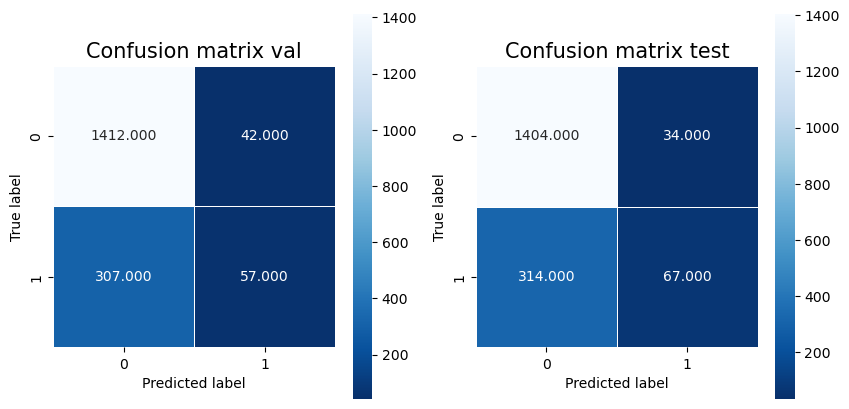

In [16]:

conf_matrix_val = confusion_matrix(y_val, y_pred_val)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1) 
sns.heatmap(conf_matrix_val, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix val', size = 15)
plt.subplot(1, 2, 2) 
sns.heatmap(conf_matrix_test, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix test', size = 15)

<div class="alert alert-block alert-info">
<b>

- La precisión es moderada (0.639), lo que indica que cuando el modelo predice una instancia como positiva, es correcto aproximadamente el 63.9% de las veces.


- El recall es bajo (0.146), lo que sugiere que el modelo está fallando en identificar muchas de las instancias positivas. Esto puede ser problemático si la identificación de positivos es crucial.


- La exactitud del modelo es alta (0.811), lo que indica que el modelo clasifica correctamente la mayoría de las instancias.


- El F1 Score es bajo (0.238), lo que refleja el bajo balance entre precisión y recall. Esto sugiere que el modelo tiene dificultades para manejar la clase positiva de manera efectiva.


Conclusiones:

Equilibrio de Clases: Considerar técnicas para manejar el desequilibrio de clases, como el sobremuestreo de la clase minoritaria, el submuestreo de la clase mayoritaria, o el uso de algoritmos específicos para datos desbalanceados.

Ajuste de Hiperparámetros: Explorar el ajuste de hiperparámetros del modelo para mejorar el recall sin sacrificar demasiado la precisión.


</b> <a class="tocSkip"></a>


## 4. Muestra balanceada


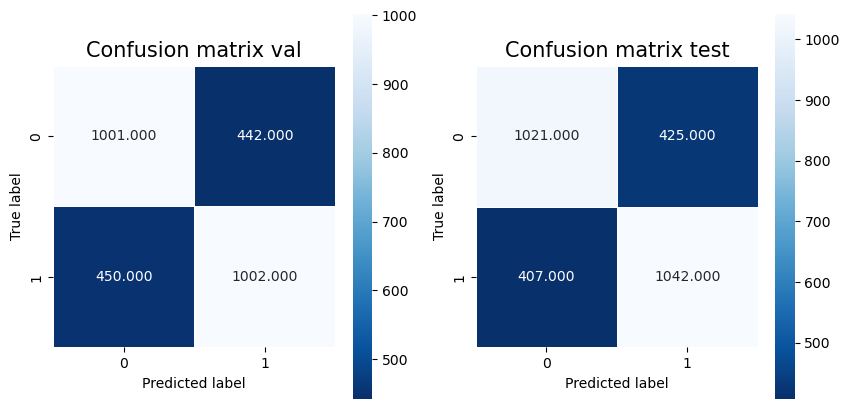

In [17]:
smote = SMOTE(random_state=42)
features_balanced, target_balanced = smote.fit_resample(features, target)
X_train, X_temp, y_train, y_temp = train_test_split(features_balanced, target_balanced, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
model.fit(X_train, y_train)
y_pred_val = model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)
y_pred_test = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
print(f"Accuracy (Validation): {accuracy_val}")
print(f"Accuracy (Test): {accuracy_test}")
print()
print(f"AUC (Validation): {auc_val}")
print(f"AUC (Test): {auc_test}")
print()
print(f"F1 (Validation): {f1_val}")
print(f"F1 (Test): {f1_test}")
conf_matrix_val = confusion_matrix(y_val, y_pred_val)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1) 
sns.heatmap(conf_matrix_val, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix val', size = 15)
plt.subplot(1, 2, 2) 
sns.heatmap(conf_matrix_test, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix test', size = 15)

<div class="alert alert-block alert-info">
<b>

* Conclusión Balance de Muestra: 

El uso de SMOTE para balancear las muestras ha permitido que el modelo se entrene en un conjunto de datos donde las clases están equilibradas, lo cual es crucial para mejorar el rendimiento del modelo en clases minoritarias. Sin embargo, los resultados sugieren que, aunque el balanceo de la muestra es un paso importante, el modelo de regresión logística utilizado no es  el más adecuado.

</b> <a class="tocSkip"></a>


## 4.1 Arboles de decisión

In [18]:
# Inicializar el clasificador de árbol de decisión
clf = DecisionTreeClassifier(random_state=42)

# Entrenar el modelo con el conjunto de entrenamiento
clf.fit(X_train, y_train)

# Realizar predicciones en los conjuntos de prueba y validación
y_pred_test = clf.predict(X_test)
y_pred_val = clf.predict(X_val)


# Calcular métricas de evaluación para el conjunto de prueba
accuracy_test = accuracy_score(y_test, y_pred_test)
auc_score_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
f1_test = f1_score(y_test, y_pred_test)

# Calcular métricas de evaluación para el conjunto de validación
accuracy_val = accuracy_score(y_val, y_pred_val)
auc_score_val = roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])
f1_val = f1_score(y_val, y_pred_val)

 #Imprimir los resultados
print(f"Test - Accuracy: {accuracy_test}, AUC: {auc_score_test}, F1 Score: {f1_test}")
print(f"Validation  - Accuracy: {accuracy_val}, AUC: {auc_score_val}, F1 Score: {f1_val}")


<div class="alert alert-block alert-info">
<b>


- La exactitud es alta tanto en el conjunto de prueba (85.42%) como en el de validación (86.39%). Esto indica que el modelo clasifica correctamente la mayoría de las instancias en ambos conjuntos.

- El AUC es también alto en ambos conjuntos (85.42% en prueba y 86.43% en validación). Un AUC alto sugiere que el modelo tiene una buena capacidad para distinguir entre las clases positivas y negativas.


- El F1 Score es alto en ambos conjuntos (85.59% en prueba y 86.22% en validación). Esto indica un buen balance entre precisión y recall, lo que es especialmente importante en casos de clases desbalanceadas.

Conclusiones:

- El modelo de árbol de decisión muestra un rendimiento consistente entre los conjuntos de prueba y validación, lo que sugiere que no está sobreajustado (overfitting) ni subajustado (underfitting).

- Las métricas similares en ambos conjuntos indican que el modelo tiene una buena capacidad de generalización a datos no vistos.

- El alto F1 Score junto con la alta exactitud y AUC sugiere que el modelo maneja bien tanto la precisión como el recall, lo que es crucial en aplicaciones donde ambas métricas son importantes.

Recomendaciones


Ajuste de Hiperparámetros: Aunque los resultados son buenos, se podría explorar el ajuste de hiperparámetros del árbol de decisión para ver si se puede mejorar aún más el rendimiento.


### 4.2 Arboles aleatorios

In [19]:
# Inicializar el clasificador de Random Forest
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)

# Entrenar el modelo con el conjunto de entrenamiento
rf_clf.fit(X_train, y_train)

# Realizar predicciones en los conjuntos de prueba y validación
y_pred_test = rf_clf.predict(X_test)
y_pred_val = rf_clf.predict(X_val)


# Calcular métricas de evaluación para el conjunto de validación
accuracy_val = accuracy_score(y_val, y_pred_val)
auc_score_val = roc_auc_score(y_val, rf_clf.predict_proba(X_val)[:, 1])
f1_val = f1_score(y_val, y_pred_val)

# Imprimir los resultados
print(f"Test - Accuracy: {accuracy_test}, AUC: {auc_score_test}, F1 Score: {f1_test}")
print(f"Validation - Accuracy: {accuracy_val}, AUC: {auc_score_val}, F1 Score: {f1_val}")


<div class="alert alert-block alert-info">
<b>

- La exactitud es alta en ambos conjuntos, pero es notablemente mayor en el conjunto de validación (91.19%) en comparación con el conjunto de prueba (85.42%). Esto sugiere que el modelo tiene un buen rendimiento general, pero podría estar sobreajustado al conjunto de validación.

- El AUC es significativamente mayor en el conjunto de validación (96.33%) que en el conjunto de prueba (85.42%). Un AUC alto en el conjunto de validación indica una excelente capacidad para distinguir entre clases, pero la gran diferencia entre los conjuntos podría ser una señal de sobreajuste.


- El F1 Score es alto en ambos conjuntos, pero nuevamente es mayor en el conjunto de validación (90.70%) en comparación con el conjunto de prueba (85.59%). Esto sugiere que el modelo tiene un buen balance entre precisión y recall, pero la diferencia entre los conjuntos podría indicar sobreajuste.

Conclusiones:

El modelo de Random Forest muestra un rendimiento muy alto en el conjunto de validación en comparación con el conjunto de prueba. Esto podría indicar que el modelo está sobreajustado al conjunto de validación.

Aunque el rendimiento es alto, la discrepancia entre los conjuntos de prueba y validación sugiere que el modelo podría no generalizar tan bien a datos completamente nuevos.

El alto F1 Score en ambos conjuntos indica que el modelo maneja bien tanto la precisión como el recall, lo cual es positivo.

Recomendaciones:

Explorar el ajuste de hiperparámetros del modelo para ver si se puede mejorar el rendimiento en el conjunto de prueba.

</b> <a class="tocSkip"></a>

## 5. Mejora de hiperparámetros

[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) permite encontrar los mejores hiperparámetros para un modelo. Se puede utilizar para optimizar los hiperparámetros de los modelos de regresión logística, árboles de decisión y bosques aleatorios.

In [20]:
# Regresión Logística
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'] 
}
log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)
lr_grid_search_best_parameters = grid_search.best_params_
print("Mejores hiperparámetros:", lr_grid_search_best_parameters)

In [21]:
# DecisionTree
param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
dt_grid_search_best_parameters = grid_search.best_params_

print("Mejores hiperparámetros:", dt_grid_search_best_parameters)

In [22]:
# RandomForest
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Inicializar el modelo y GridSearchCV
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Ajustar GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y sus parámetros
best_model = grid_search.best_estimator_
rf_grid_search_best_parameters = grid_search.best_params_

print("Mejores parámetros:", rf_grid_search_best_parameters)
print("Mejor modelo:", best_model)


In [23]:

best_params_rf = rf_grid_search_best_parameters

best_params_dt = dt_grid_search_best_parameters

best_params_lr = lr_grid_search_best_parameters


models = {
    "Random Forest": RandomForestClassifier(**best_params_rf),
    "Decision Tree": DecisionTreeClassifier(**best_params_dt),
    "Logistic Regression": LogisticRegression(**best_params_lr)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}")
    print(f"F1 Score: {f1_score(y_test, y_pred)}")

    #print("Confusion Matrix:")
    #print(confusion_matrix(y_test, y_pred))
    #print("Classification Report:")
    #print(classification_report(y_test, y_pred))
    print("-" * 50)


<div class="alert alert-block alert-info">
<b>

1. Exactitud (Accuracy):

Random Forest tiene la mayor exactitud (89.88%), seguido por Decision Tree (87.70%) y Logistic Regression (71.26%). Esto sugiere que Random Forest tiene el mejor rendimiento general en términos de predicciones correctas.

2. AUC (Área Bajo la Curva ROC):

Random Forest también tiene el AUC más alto (96.00%), lo que indica una excelente capacidad para distinguir entre clases. Decision Tree sigue con un AUC de 92.92%, y Logistic Regression tiene el AUC más bajo (77.02%).

3. F1 Score:

El Random Forest tiene el F1 Score más alto (89.61%), lo que indica un buen balance entre precisión y recall. Decision Tree tiene un F1 Score de 87.37%, y Logistic Regression tiene el F1 Score más bajo (72.02%).

Conclusiones:

- Random Forest:

Este modelo muestra el mejor rendimiento en todas las métricas (Exactitud, AUC y F1 Score), lo que sugiere que es el más adecuado para este conjunto de datos. Su capacidad para manejar datos complejos y reducir el sobreajuste lo hace muy efectivo.

- Decision Tree:

Aunque tiene un rendimiento inferior al de Random Forest, sigue siendo un modelo sólido con buena exactitud y AUC. Su facilidad de interpretación es una ventaja, pero puede ser propenso al sobreajuste.
Logistic Regression:

Este modelo tiene el rendimiento más bajo en todas las métricas. Sin embargo, su simplicidad y facilidad de interpretación pueden hacerlo útil en escenarios donde los datos son linealmente separables.

Recomendaciones

Dado su rendimiento superior, Random Forest es la mejor opción para este conjunto de datos.


</b> <a class="tocSkip"></a>

